In [1]:
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
ANNOTATION_DIR = R"C:\Users\user\AppData\Roaming\Godot\app_userdata\GodotWebsocketServer\gold_annotation"

In [3]:
file_pattern = os.path.join(ANNOTATION_DIR, "*.csv")
csv_files = glob.glob(file_pattern)
print(len(csv_files))
df = pd.concat(map(pd.read_csv, csv_files), ignore_index=True)

8


In [4]:
len(df)

269

In [5]:
df.head()

,gyro_x_0,gyro_y_0,gyro_z_0,accel_x_0,accel_y_0,accel_z_0,gyro_x_1,gyro_y_1,gyro_z_1,accel_x_1,...,accel_x_4,accel_y_4,accel_z_4,gyro_x_5,gyro_y_5,gyro_z_5,accel_x_5,accel_y_5,accel_z_5,motion_type
0,0.094428,-0.720844,0.777013,0.89025,-12.843750,-2.612513,0.00000,0.000000,0.000000,0.00000,...,3.879000,-3.748950,-8.397000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,HIT
1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-0.05885,-0.298650,0.524517,5.39300,...,-76.785004,70.759056,21.894001,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,HIT
2,0.073253,-0.283078,0.453750,4.65600,-12.122776,-1.741500,0.00000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,HIT
3,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-2.06723,-0.871613,-6.555670,-12.05658,...,0.027000,-3.603000,3.202950,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,HIT
4,0.000000,0.000000,0.000000,4.27395,-34.944000,-38.773052,0.65890,11.824312,-11.209413,6.69300,...,5.471475,-6.936975,-1.344000,0.109587,0.174694,0.17435,6.108525,-8.61555,-2.526975,HIT


<Axes: xlabel='motion_type', ylabel='count'>

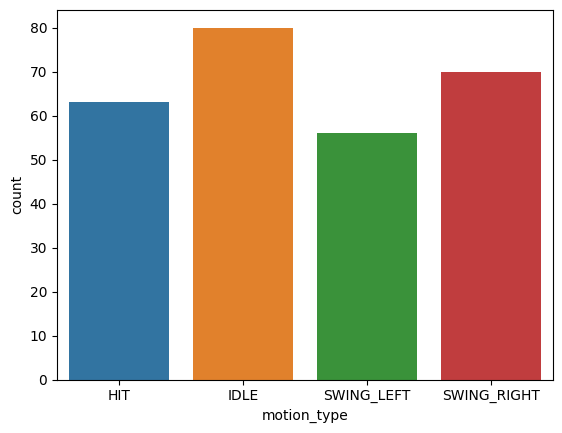

In [6]:
sns.countplot(df, x="motion_type", hue="motion_type")

In [7]:
X_df = df.drop(columns=["motion_type"])
y = df["motion_type"].values

In [8]:
n_timesteps = 6
channels = ["gyro_x", "gyro_y", "gyro_z", "accel_x", "accel_y", "accel_z"]
n_channels = len(channels)

X = np.zeros((len(df), n_channels, n_timesteps))

for t in range(n_timesteps):
    for c, channel in enumerate(channels):
        col_name = f"{channel}_{t}"
        X[:, c, t] = X_df[col_name].values

In [9]:
def left_zero_pad(X, target_timesteps=9):
    """
    X shape: (n_samples, n_channels, n_timesteps)
    """
    n_samples, n_channels, n_timesteps = X.shape
    pad = target_timesteps - n_timesteps

    if pad <= 0:
        return X

    padding = np.zeros((n_samples, n_channels, pad))
    X_padded = np.concatenate([padding, X], axis=2)
    return X_padded

In [10]:
X = left_zero_pad(X, target_timesteps=9)
print(X.shape)  # (n_samples, 6, 9)

(269, 6, 9)


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_enc = le.fit_transform(y)

In [12]:
from sktime.transformations.panel.rocket import MiniRocketMultivariate
from sklearn.linear_model import RidgeClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.deep_learning import InceptionTimeClassifier
from sklearn.pipeline import make_pipeline

In [13]:
# clf_minirocket = make_pipeline(
#     MiniRocketMultivariate(random_state=42),
#     RidgeClassifier(alpha=1.0)
# )
# clf_minirocket = KNeighborsTimeSeriesClassifier()
clf_minirocket = InceptionTimeClassifier()

clf_minirocket.fit(X, y_enc)

InceptionTimeClassifier()

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [15]:
precision_macro = make_scorer(
    precision_score, average="macro", zero_division=0
)

recall_macro = make_scorer(
    recall_score, average="macro", zero_division=0
)

f1_macro = make_scorer(
    f1_score, average="macro", zero_division=0
)

In [16]:
scores_accuracy = cross_val_score(
    clf_minirocket, X, y_enc, cv=5, scoring="accuracy"
)

scores_precision = cross_val_score(
    clf_minirocket, X, y_enc, cv=5, scoring=precision_macro
)

scores_recall = cross_val_score(
    clf_minirocket, X, y_enc, cv=5, scoring=recall_macro
)

scores_f1 = cross_val_score(
    clf_minirocket, X, y_enc, cv=5, scoring=f1_macro
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 817ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


In [17]:
print("MiniRocket Accuracy :", scores_accuracy.mean(), "±", scores_accuracy.std())
print("MiniRocket Precision:", scores_precision.mean(), "±", scores_precision.std())
print("MiniRocket Recall   :", scores_recall.mean(), "±", scores_recall.std())
print("MiniRocket F1-score :", scores_f1.mean(), "±", scores_f1.std())

MiniRocket Accuracy : 0.86638714185884 ± 0.04991181380523474
MiniRocket Precision: 0.9029066154433802 ± 0.0599377101156355
MiniRocket Recall   : 0.8708853646353646 ± 0.06319842168186118
MiniRocket F1-score : 0.8663982493871206 ± 0.06015558410074197
